**Units & conventions.** 

We work in geometrized units $(G=c=1)$ with $(M\equiv1)$. Screen coordinates $(b,\alpha)$ follow Bardeen. Observer polar angle is $\theta_0$.


In [62]:
import sympy as sp
import jax
import jax.numpy as jnp
import numpy as np
import diffrax
import matplotlib.pyplot as plt

In [63]:
m, a = sp.symbols('m a')
r, th = sp.symbols('r th')
pt, pr, pth, pphi = sp.symbols('pt pr pth pphi')


Sigma = r**2 + a**2 * sp.cos(th)**2
Delta = r**2 - 2*m*r + a**2

g_tt = -(1 - (2*m*r)/Sigma)
g_rr = Sigma / Delta
g_thth = Sigma
g_phiphi = ( (r**2 + a**2 + (2*m*a**2*r*sp.sin(th)**2)/Sigma) * sp.sin(th)**2 )
g_tphi = -(2*m*a*r*sp.sin(th)**2)/Sigma


D = g_tphi**2 - g_tt * g_phiphi


E = -pt
L = pphi
H = (1/2) * (
    pr**2 / g_rr
    + pth**2 / g_thth
    - (L**2 * g_tt + 2*E*L * g_tphi + E**2 * g_phiphi) / D
)


tdot = sp.diff(H, pt)
rdot = sp.diff(H, pr)
thdot = sp.diff(H, pth)
phidot = sp.diff(H, pphi)
prdot = -sp.diff(H, r)
pthdot = -sp.diff(H, th)


modules = ["jax", {"sqrt": jnp.sqrt, "sin": jnp.sin, "cos": jnp.cos}]

tdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), tdot, modules=modules)
rdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), rdot, modules=modules)
thdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), thdot, modules=modules)
phidot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), phidot, modules=modules)
prdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), prdot, modules=modules)
pthdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), pthdot, modules=modules)

**Screen → momenta.** 

We set $E=1$, $p_t=-E$, $p_\phi=-b\,E\sin\theta_0$. 

This matches the Bardeen mapping used in the paper.


In [75]:
@jax.jit
def initial_vector_batch(r0, th0, b_list, al_list, metric_params, E=1.0, inward=True):
    batch_size = b_list.shape[0]

    t0 = jnp.zeros(batch_size)
    L_list = -b_list * E * jnp.sin(th0)      
    vth0_list = al_list / (r0 ** 2)

    m_val = metric_params['m']
    a_val = metric_params['a']

    
    Σ = r0**2 + a_val**2 * jnp.cos(th0)**2
    Δ = r0**2 - 2*m_val*r0 + a_val**2

    g_tt_val    = -(1.0 - (2.0*m_val*r0)/Σ)
    g_tphi_val  = - (2.0*m_val*a_val*r0/Σ) * jnp.sin(th0)**2
    g_phiphi_val = (r0**2 + a_val**2 + (2.0*m_val*a_val**2*r0*jnp.sin(th0)**2)/Σ) * jnp.sin(th0)**2
    g_rr_val    = Σ / Δ
    g_thth_val  = Σ
    D_val       = g_tphi_val**2 - g_tt_val * g_phiphi_val

    E_val = E
    L_val = L_list

    
    vt0 = (E_val * g_phiphi_val + L_val * g_tphi_val) / D_val

    vth0_sq = vth0_list ** 2
    numerator = (
        (L_val**2 * g_tt_val + 2.0 * E_val * L_val * g_tphi_val + E_val**2 * g_phiphi_val) / D_val
        - vth0_sq * g_thth_val
    )
    vr0_sq = numerator / g_rr_val
    vr0 = jnp.sqrt(jnp.abs(vr0_sq))
    vr0 = jnp.where(inward, -vr0, vr0)

    pr0   = g_rr_val   * vr0
    pth0  = g_thth_val * vth0_list
    pt0   = -E_val * jnp.ones(batch_size)
    pphi0 = L_val
    φ0    = jnp.zeros(batch_size)

    I0 = jnp.zeros(batch_size)

    y0 = jnp.stack([
        t0,
        r0 * jnp.ones(batch_size),
        th0 * jnp.ones(batch_size),
        φ0,
        pr0, pth0, pt0, pphi0,
        I0
    ], axis=1)
    return y0

**Keplerian rotation.** 

The azimuthal angular velocity is  
$$
\Omega=\frac{\sqrt{M}}{(r\sin\theta)^{3/2}+a\sqrt{M}},
$$
as in Eq. (3). The fluid 4–velocity is normalized by $g_{\mu\nu}u^\mu u^\nu=-1$.


In [76]:
@jax.jit
def calculate_azimuthal_velocity(r, theta, a_value, m_value):
    omega=(jnp.sqrt(m_value)/((r*jnp.sin(theta))**(3/2)+a_value*jnp.sqrt(m_value))) 
    
    vphi_fluid = omega
    return vphi_fluid

**BLR emissivity.** 

We use two optically-thin profiles (paper Eqs. (1)–(2)):  
(i) $j_0 \propto \exp\!\big[-(r-R_{\rm in})/r_{\rm scale}\big]\exp(-\kappa|\cos\theta|)$,  
(ii) $j_0 \propto (r/R_{\rm in})^{-p}\exp(-\kappa|\cos\theta|)$, with $\kappa=10$.  
Disk geometry: $500M<\varpi<1000M$ and $|z|<15M$.


In [77]:
@jax.jit
def density_BLR_3d(r, theta, phi):


    R_in  = 500.0
    R_out = 1000.0
    

    rho0       = 1.0       
    r_scale    = 2000.0    
    

    alpha      = 0.1       
    

    z = r * jnp.cos(theta)
    

    radial_factor = rho0 * jnp.exp(-(r - R_in) / r_scale)
    

    H_r = alpha * r
    vertical_factor = jnp.exp(-jnp.abs(z) / H_r)
    

    density_3d = radial_factor * vertical_factor
    density_3d = jnp.where((r >= R_in) & (r <= R_out), density_3d, 0.0)
    
    return density_3d

@jax.jit
def density_BLR_3d_powerlaw(r, θ, φ):
    R_in, R_out = 500.0, 1000.0
    ρ0 = 1.0
    p   = 2.5   
    α   = 0.1


    z = r * jnp.cos(θ)


    radial_factor = ρ0 * jnp.where(r > R_in,
                                    (r / R_in) ** (-p),
                                    0.0)


    H_r = α * r
    vertical_factor = jnp.exp(-jnp.abs(z) / H_r)

    ρ = radial_factor * vertical_factor

    ρ = jnp.where((r >= R_in) & (r <= R_out), ρ, 0.0)
    return ρ

**Lorentz-invariant transfer.** 

Along null rays we integrate  
$$
dI_\nu=\gamma^{2}j_0 d\lambda,
$$
with $\gamma=E_{\rm obs}/E_0$. Absorption is neglected (optically thin). 


In [78]:
@jax.jit
def intensity_at_point(points_4_velocity, E0, a_value, m_value):
    λ, t, r, theta, phi, vt, vr, vtheta, vphi = points_4_velocity
    z = r * jnp.cos(theta)
    #density = 1 / r ** 2
    density=  density_BLR_3d_powerlaw(r,theta,phi)

    Σ = r**2 + a_value**2 * jnp.cos(theta)**2
    Δ = r**2 - 2.0*m_value*r + a_value**2

    g = jnp.array([
        [-(1.0 - (2.0*m_value*r)/Σ),                           0.0,       0.0,   -(2.0*m_value*a_value*r/Σ)*jnp.sin(theta)**2],
        [0.0,                                                  Σ/Δ,       0.0,    0.0],
        [0.0,                                                  0.0,       Σ,      0.0],
        [-(2.0*m_value*a_value*r/Σ)*jnp.sin(theta)**2,         0.0,       0.0,   (r**2 + a_value**2 + (2.0*m_value*a_value**2*r*jnp.sin(theta)**2)/Σ)*jnp.sin(theta)**2]
    ])


    k_0 = jnp.dot(g, jnp.array([vt, vr, vtheta, vphi]))

    vphi_fluid = calculate_azimuthal_velocity(r, theta, a_value, m_value)
    u_0_candidate = jnp.array([1.0, 0.0, 0.0, vphi_fluid])

    dot_product = jnp.dot(u_0_candidate, jnp.dot(g, u_0_candidate))
    vt_fluid = jnp.sqrt(-1 / dot_product)
    vphi_fluid = vphi_fluid * vt_fluid
    u_0 = jnp.array([vt_fluid, 0.0, 0.0, vphi_fluid])

    k_0_u_0 = jnp.dot(k_0, u_0)
    E_obs = -1 / k_0_u_0
    gamma_inv = 1 / E_obs


    alpha0 = 0.0
    optical_depth = gamma_inv * alpha0

    j0 = density
    intensity = gamma_inv * (j0 / E0**3) * E_obs**3
    ratio = E_obs / E0

    return intensity, ratio

In [79]:
@jax.jit
def eom_system(t, y, args):

    t_var, r_val, th_val, phi_val, pr_val, pth_val, pt_val, pphi_val, I_val = y
    m_val, a_val, E0 = args  


    dt_dλ = tdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
    dr_dλ = rdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
    dth_dλ = thdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
    dphi_dλ = phidot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val,)
    dpr_dλ = prdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
    dpth_dλ = pthdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
    dpt_dλ = 0.0
    dpphi_dλ = 0.0 


    vt = dt_dλ
    vr = dr_dλ
    vtheta = dth_dλ
    vphi = dphi_dλ


    points_4_velocity = [t, t_var, r_val, th_val, phi_val, vt, vr, vtheta, vphi]


    intensity_increment = jax.lax.cond(
        disk_intersection(y),
        lambda _: intensity_at_point(points_4_velocity, E0, a_val, m_val)[0],
        lambda _: 0.0,
        operand=None
    )


    dI_dλ = intensity_increment


    dy_dt = jnp.array([
        dt_dλ, dr_dλ, dth_dλ, dphi_dλ,
        dpr_dλ, dpth_dλ, dpt_dλ, dpphi_dλ, dI_dλ
    ])
    return dy_dt



@jax.jit
def disk_intersection(y):
    r_val = y[1]
    th_val = y[2]
    phi_val = y[3]
    z = r_val * jnp.cos(th_val)
    rho = r_val*jnp.sin(th_val)
    in_rho = jnp.logical_and(500 < rho, rho < 1000)
    in_z = jnp.logical_and(-15 < z, z < 15)
    return jnp.logical_and(in_rho, in_z)

**Termination.** 

Integration stops at $r=r_+ + \varepsilon$ with $r_+=M+\sqrt{M^2-a^2}$.


In [80]:
metric_params = {'m': 1.0, 'a': 0.0}
args_array = jnp.array([metric_params['m'], metric_params['a']])
E0 = 1.0  
args_array = jnp.array([metric_params['m'], metric_params['a'], E0])

ode_term = diffrax.ODETerm(eom_system)

def event_function(t, y, args):
    _, r_val, _, _, _, _, _, _, _ = y
    m_val, a_val, E0 = args
    r_plus = m_val + jnp.sqrt(jnp.maximum(0.0, m_val**2 - a_val**2))
    epsilon = 1e-3
    return r_val - (r_plus + epsilon)





solver = diffrax.Tsit5()

In [81]:
def event_function_wrapper(t, y, args, **kwargs):
    return event_function(t, y, args)

event = diffrax.Event(cond_fn=event_function_wrapper)

In [82]:
resolution_x = 100
resolution_y = 100


b_values = jnp.linspace(-200, 200, resolution_x)
al_values = jnp.linspace(-100, 100, resolution_y)


b_grid, al_grid = jnp.meshgrid(b_values, al_values, indexing='ij')
b_list_full = b_grid.ravel()
al_list_full = al_grid.ravel()


b_list_filtered=b_list_full
al_list_filtered=al_list_full


r0 = 10000
th0 = (85.0*jnp.pi / 2)/90
E = 1.0
t0 = 0.0
t1 = 15000.0
dt0 = 0.025

inward = True
metric_params = {'m': 1.0, 'a': 0.998}
args_array = jnp.array([metric_params['m'], metric_params['a'], E])

y0s = initial_vector_batch(
    r0, th0, b_list_filtered, al_list_filtered,
    metric_params, E=E, inward=inward
)


argss = jnp.tile(args_array, (b_list_filtered.shape[0], 1))


jax.config.update("jax_enable_x64", True)
controller = diffrax.PIDController(rtol=1e-11, atol=1e-12,dtmin=0.01, force_dtmin=True)  
from functools import partial

def solve_single_trajectory(y0, args, ode_term, solver):

    
    solution = diffrax.diffeqsolve(
        terms=ode_term,
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        args=args,
        max_steps=1500000,
        event=event,
        stepsize_controller=controller,
        saveat=diffrax.SaveAt(t1=True)
    )
    final_state = solution.ys[-1]
    final_time = solution.ts[-1]
    return final_state, final_time


In [83]:
solve_single_trajectory_jit = jax.jit(
    solve_single_trajectory,
    static_argnames=('ode_term', 'solver')
)
# vectorize using vmap
solve_trajectories = jax.vmap(
    solve_single_trajectory_jit,
    in_axes=(0, 0, None, None)
)




final_results = solve_trajectories(y0s, argss, ode_term, solver)
final_states, final_times = final_results
final_states_np = np.array(final_states)
final_intensities = final_states_np[:, -1]


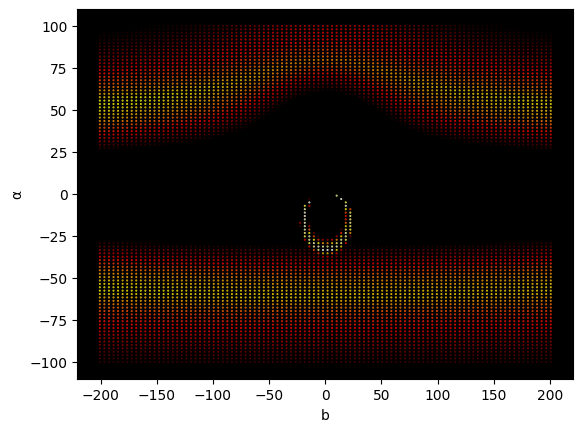

In [84]:
b_values_np = np.array(b_list_filtered)
al_values_np = -np.array(al_list_filtered)
th0_val = (85.0*jnp.pi / 2)/90
b_local = b_values_np / np.sin(th0_val)
final_intensities_np = np.array(final_intensities)


fig, ax = plt.subplots()

threshold = 5


mask = final_intensities_np > threshold

ax.set_facecolor('black')

plt.scatter(
    b_local[mask],
    al_values_np[mask],
    c=final_intensities_np[mask],
    s=0.2,
    cmap='hot'
)
plt.xlabel('b')
plt.ylabel('α')
plt.show()